In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import json, pymongo, pandas
import numpy as np

In [3]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [102]:
def connect_to_database(): 
    # load credentials to access the database, connect, identify collection
    data = json.load(open('./.credentials/auth.json'))
    mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
    connection = pymongo.MongoClient(mongo_tunnel)
    data_base = connection['sleep_affect_memory']
    collection = data_base['replication']
    return collection

In [103]:
def identify_workers(collection):
    
    # the second is my worker id
    exclude = ['NONE', 'A33F2FVAMGJDGG']
    all_workers = [i for i in collection.distinct('worker_id') if i not in exclude]
    
    # extract workers who've completed entire experiment -- not returned HIT early
    complete = [] 
    for i_worker in all_workers: 
        tmp_data = collection.find({'worker_id':i_worker})
        if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
            complete.append(i_worker)
    
    return complete

In [104]:
def extract_data(w_ids): 
    
    # columns to exclude 
    ignore = ['trial_index', 
              'time_elapsed', 
              'stimulus', 
              'correct_response', 
              'internal_node_id', 
              'trial_type']
    
    subject_trial_data = pandas.DataFrame()
    
    # iterate over workers 
    for i_worker in w_ids: 
        
        # extract worker's data from mongo database
        i_data = collection.find({'worker_id':i_worker})

        for one_trial in i_data: 
            
            # extract all data we want 
            if 'worker_feedback' not in one_trial['trial_data'].keys(): 
                q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
                q['subject'] = one_trial['worker_id']
                subject_trial_data = subject_trial_data.append(q, ignore_index=True)
    
    # convert to absolute value of distance
    subject_trial_data.distance = np.abs(subject_trial_data.distance)
    
    return subject_trial_data

In [105]:
collection = connect_to_database()
worker_ids = identify_workers(collection)
trial_data = extract_data(worker_ids)

In [106]:
generalization_data = trial_data[trial_data.stage=='generalization']
generalization_data = generalization_data[generalization_data.valence!='control']

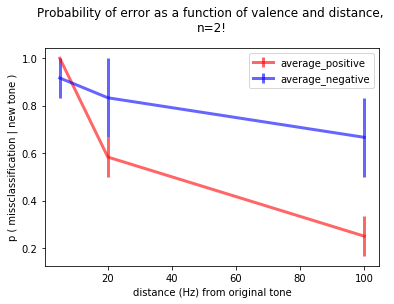

In [107]:
tones =  [i for i in np.sort(generalization_data.distance.unique()) if i != 0 ]
valences = ['positive', 'negative']
generalization_curves = {j:{i:[] for i in tones} for j in valences}
colores = {'positive':'red', 'negative':'blue'}

need_legend = 1
for i_subject in worker_ids: 
    
    gen_data = generalization_data[generalization_data.subject==i_subject]
    
    for i_valence in valences: 
        
        generalization_curve = []
        for i_tone in tones: 

            conditions = (gen_data.valence == i_valence) & (gen_data.distance == i_tone)
            generalization_curve.append(1-gen_data[conditions].correct.mean())
            generalization_curves[i_valence][i_tone].append(1-gen_data[conditions].correct.mean())
        
        #plot(tones, generalization_curve,  color=colores[i_valence], linewidth=2, alpha=.1)

for i_valence in valences: 
    errorbar(tones, 
             [mean(generalization_curves[i_valence][i]) for i in tones],
             yerr=[std(generalization_curves[i_valence][i]) for i in tones], 
             color=colores[i_valence], linewidth=3, label='average_%s'%i_valence, 
             alpha=.6)
legend() 
ylabel('p ( missclassification | new tone )')
xlabel('distance (Hz) from original tone'); 
title('Probability of error as a function of valence and distance, \nn=2!', y=1.05); 

In [108]:
main_question_conditions = (generalization_data.valence != 'control')
valence_by_distance = generalization_data[main_question_conditions][['correct', 'distance', 'valence']]

In [109]:
valence_by_distance[0:10]

,correct,distance,valence
33,0.0,5.0,positive
34,0.0,5.0,positive
35,0.0,20.0,positive
36,0.0,0.0,negative
37,1.0,20.0,negative
38,0.0,5.0,negative
39,0.0,20.0,positive
42,1.0,100.0,positive
43,0.0,100.0,negative
44,1.0,0.0,positive


In [110]:
from statsmodels.formula.api import ols
model = ols("correct ~ distance * valence", valence_by_distance).fit()

In [111]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.069
Date:                Wed, 28 Nov 2018   Prob (F-statistic):             0.0312
Time:                        23:43:28   Log-Likelihood:                -72.606
No. Observations:                 108   AIC:                             153.2
Df Residuals:                     104   BIC:                             163.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [112]:

### add 'neg', 'pos', 'new' data into the keys
### save keys, not numbers! 


In [200]:
keys = {'positive':np.zeros(len(td)), 'negative':np.zeros(len(td))}

for i_subject in trial_data.subject.unique(): 

    for i_valence in ['positive', 'negative']: 
        
        ifs = (td.correct==1) & (td.condition == 'instrumental') & (td.valence==i_valence)
        keys[i_valence][td.subject==i_subject] = (td[ifs].key_press.unique()[0])
        

In [258]:

re = {80:0,81:1,32:2}
generalization_data['key'] = [re[i] for i in generalization_data.key_press.values]
generalization_data['response'] = [{80:'positive',81:'negative',32:'neutral'}[i] for i in generalization_data.key_press.values]


Text(0.5,1.05,'something is wrong with our "correct" labels')

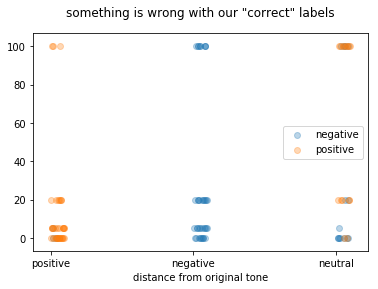

In [276]:
for i_valence in ['negative', 'positive']: 
    plt.scatter(generalization_data[generalization_data.valence==i_valence].key.values + .1*np.random.rand(sum(generalization_data.valence=='positive')),  
                generalization_data[generalization_data.valence==i_valence].distance.values, 
                alpha=.3, label=i_valence)


xticks([0,1,2], ['positive', 'negative', 'neutral'])
legend() 
xlabel('distance from original tone')
title('something is wrong with our "correct" labels', y=1.05)

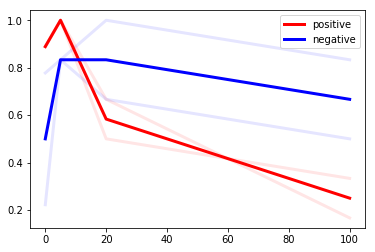

In [291]:
colores = {'positive':'red', 'negative':'blue'}

distances = np.sort(generalization_data.distance.unique())
all_things = {'positive':[], 'negative':[]}

for i_subject in generalization_data.subject.unique(): 
    
    for i_valence in ['positive', 'negative']: 
        
        things = [] 
        
        for i_distance in distances: 
        
            gen = generalization_data[generalization_data.subject==i_subject]
            conditions = (gen.valence==i_valence)*(gen.distance==i_distance)
            things.append(mean(gen.response[conditions] == gen.valence[conditions]))
        
        all_things[i_valence].append(things)
        plot(distances, things, color=colores[i_valence], alpha=.1, linewidth=3)

plot(distances, np.mean(all_things['positive'],0), color='red', linewidth=3, label='positive')
plot(distances, np.mean(all_things['negative'],0), color='blue', linewidth=3, label='negative')
legend() 
